In [344]:
import numpy as np
from matplotlib import pyplot as plt
import scipy

In [345]:
import numpy as np

def read_dca1000(file_name, num_adc_samples = 256, num_adc_bits = 16, num_rx = 4):
    """
    Reads the binary file produced by the DCA1000 and Mmwave Studio.
    
    Args:
        file_name (str): Path to the .bin file.
        
    Returns:
        np.ndarray: A numpy array of shape (numRX, numChirps * numADCSamples) containing complex data.
    """
    
    # --- Global Variables (Change based on sensor config) ---
    # num_adc_samples = 256    # number of ADC samples per chirp
    # num_adc_bits = 16        # number of ADC bits per sample
    # num_rx = 4               # number of receivers
    num_lanes = 2            # do not change. number of lanes is always 2
    is_real = False          # set to True if real only data, False if complex data

    # --- Read File ---
    # Read .bin file as int16
    try:
        adc_data = np.fromfile(file_name, dtype=np.int16)
    except FileNotFoundError:
        print(f"Error: File {file_name} not found.")
        return None

    # If 12 or 14 bits ADC per sample compensate for sign extension
    if num_adc_bits != 16:
        l_max = 2**(num_adc_bits-1) - 1
        adc_data[adc_data > l_max] -= 2**num_adc_bits

    file_size = adc_data.size

    # --- Process Data ---
    if is_real:
        # Real data reshape
        num_chirps = file_size // (num_adc_samples * num_rx)
        
        # Reshape to match MATLAB's column-major (F) logic
        lvds = adc_data.reshape(num_adc_samples * num_rx, num_chirps, order='F')
        lvds = lvds.T 
    else:
        # Complex data
        # File size is halved because 2 integers make 1 complex number
        num_chirps = file_size // (2 * num_adc_samples * num_rx)
        
        # The DCA1000 usually interleaves data in a specific pattern for 2 lanes:
        # [Real1, Real2, Imag1, Imag2, Real3, Real4, Imag3, Imag4...]
        # We reshape to (-1, 4) to separate these chunks
        adc_data = adc_data.reshape(-1, 4)
        
        # Construct complex data
        # Real parts are columns 0 and 1; Imaginary parts are columns 2 and 3
        data_real = adc_data[:, [0, 1]].flatten()
        data_imag = adc_data[:, [2, 3]].flatten()
        complex_data = data_real + 1j * data_imag
        
        # Reshape to dimensions: (SamplesPerChirp * NumRX) x NumChirps
        # We use order='F' to mimic MATLAB's default column-filling behavior
        lvds = complex_data.reshape(num_adc_samples * num_rx, num_chirps, order='F')
        
        # Transpose to get (NumChirps) x (SamplesPerChirp * NumRX)
        lvds = lvds.T

    # --- Organize Data per RX ---
    # Currently, lvds shape is (num_chirps, num_rx * num_adc_samples)
    # The columns are packed as: [RX1_Samples | RX2_Samples | RX3_Samples | RX4_Samples]
    
    # 1. Reshape to separate RX channels: (NumChirps, NumRX, NumSamples)
    lvds = lvds.reshape(num_chirps, num_rx, num_adc_samples)
    
    # 2. Transpose to bring RX to the front: (NumRX, NumChirps, NumSamples)
    lvds = lvds.transpose(1, 0, 2)
    
    # 3. Flatten the last two dimensions to get continuous samples per RX
    # Final Shape: (NumRX, NumChirps * NumSamples)
    ret_val = lvds.reshape(num_rx, -1)

    return ret_val

# Example Usage:
# radar_data = read_dca1000('adc_data.bin')
# print(radar_data.shape)

In [346]:
# fileName="Sitting1Tx1Rx/static_sitting2.bin"
# fileName="Sitting1Tx1Rx/static_sitting3_Raw_0.bin"
fileName="Sitting1Tx1Rx/static_sitting_no_breathing4.bin"
# fileName="Sitting1Tx1Rx/static_sitting_heavy_breathing2.bin"
dca_out=read_dca1000(fileName, num_rx=1)

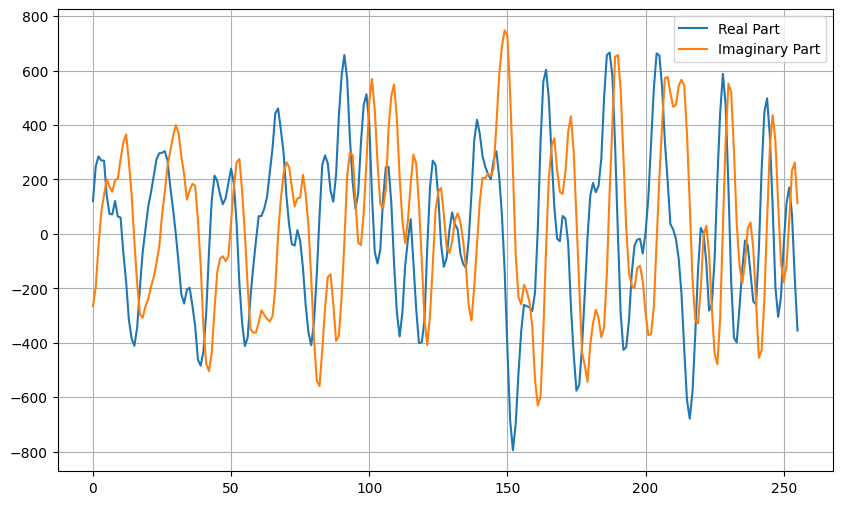

In [347]:
# Time domain
plt.figure(figsize=(10, 6))
chirp=0
data=dca_out[0][chirp*256:(chirp+1)*256]
real=data.real
complex_data=data.imag
plt.plot(real,label='Real Part')
plt.plot(complex_data,label='Imaginary Part')
plt.grid()
plt.legend()

In [348]:
print(dca_out)
print(dca_out.shape)

[[ 120.-266.j  247.-196.j  285. -46.j ... -149.+303.j -374.+272.j
  -568.+134.j]]
(1, 4194304)


In [349]:
sampling_frequency = 10000 * 1e3 # Hz (example)
S=29.982 * 1e12 #mhz/us
start_freq=77*1e9
ramp_end=60 #us
idle_time=100 #us
periodicity=40 #us
chirp_cycle_time=(idle_time + ramp_end + periodicity) * 1e-6
pulse_repetation_interval = 1/chirp_cycle_time
num_rx=1
num_chirps=1
samples_per_chirp=256
chirps_per_frame=128
range_max=3e8*sampling_frequency/ (2*S)

frames_per_loop=128
chirp_loops=128

dca_out.shape[1]/samples_per_chirp/chirp_loops/frames_per_loop

1.0

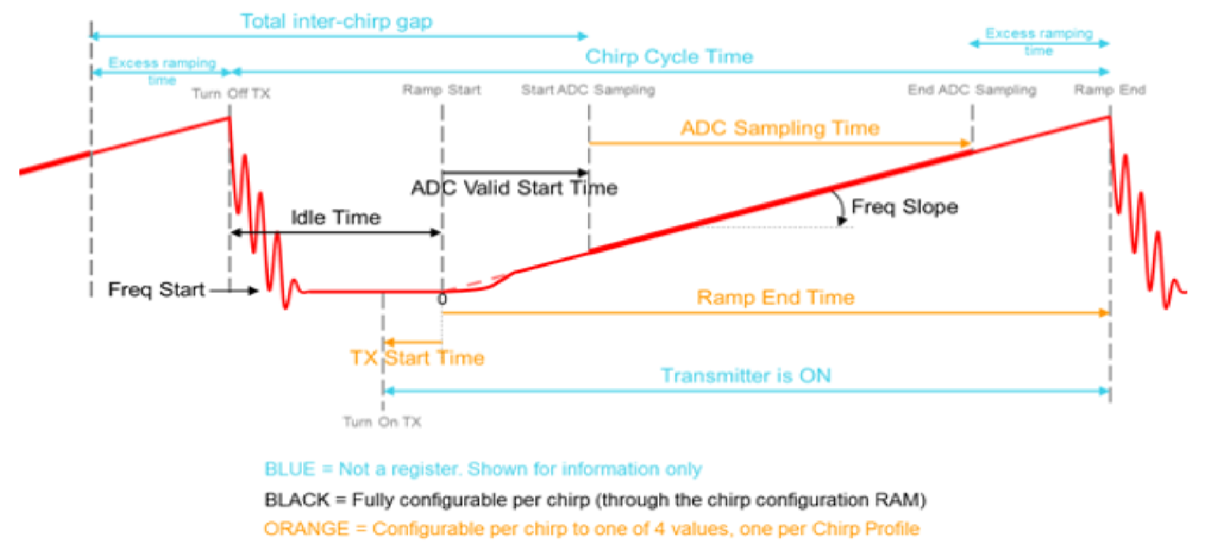

In [350]:
dca_out[0][0]

np.complex128(120-266j)

In [351]:
window = np.hanning(256)
print(window.shape)
print(window[np.newaxis, :].shape)

(256,)
(1, 256)


In [352]:
def magnitude_dbfs(fft_data, adc_bits=16):
        """
        Convert complex FFT to magnitude in dBFS (decibels relative to full scale)
        
        Args:
            fft_data: Complex FFT output array
            adc_bits: ADC resolution in bits (default 12-bit for typical radar)
        
        Returns:
            magnitude_dbfs: Magnitude in dBFS scale
        """
        # Calculate full scale value based on ADC bits
        full_scale = 2**(adc_bits - 1)  # For signed ADC
        
        # Get magnitude of FFT
        magnitude = np.abs(fft_data)
        
        # Normalize by FFT length (important for proper scaling)
        magnitude_normalized = magnitude / len(fft_data)
        
        # Convert to dBFS: 20*log10(magnitude / full_scale)
        # Add small epsilon to avoid log(0)
        magnitude_dbfs = 20 * np.log10(magnitude_normalized / full_scale + 1e-10)
        
        return magnitude_dbfs

def magnitude_db(fft_data):
        """Convert complex FFT to magnitude in dB"""
        magnitude = np.abs(fft_data)
        magnitude_db = 20 * np.log10(magnitude + 1e-10)  # Add small value to avoid log(0)
        return magnitude_db

def rangeFFT(signal, plot=False):
    global range_max
    num_samples = len(signal)
    window = np.hanning(num_samples)
    signal_windowed = signal * window
    y=np.fft.fft(signal_windowed)
    fft_magnitude = magnitude_db(y,)
    # fft_magnitude = magnitude_dbfs(y,adc_bits=16)

    # frequencies = np.fft.fftshift(np.fft.fftfreq(num_samples, d=1/(sampling_frequency)))
    # distances=np.abs(frequencies)*3e8/2/S
    distances=np.arange(num_samples) * range_max / num_samples
    # print([distances[0],distances[-100]])
    if plot:
        # Plot the magnitude spectrum
        plt.figure(figsize=(10, 5))
        # plt.plot(frequencies[:num_samples//2], fft_magnitude[:num_samples//2]) # Plot only positive frequencies
        # plt.plot(distances[:num_samples//2], fft_magnitude[:num_samples//2]) # Plot only positive frequencies
        plt.plot(distances, fft_magnitude) # Plot only positive frequencies
        plt.title('Magnitude Spectrum (Range Profile)')
        # plt.xlabel('Frequency (Hz) / Range Bins')
        plt.xlabel('Distances (m)')
        plt.ylabel('Magnitude [dBFS]')
        plt.xticks(np.arange(0,range_max,5))
        plt.grid(True)
        plt.axvline(x=0.6, color='r', linestyle='--', alpha=0.5)
        plt.show()
    return y, fft_magnitude, distances

magAt58cm=[]
sigAt58cm=[]
distances_all=[]
for chirp_no in range(len(dca_out[0])//samples_per_chirp):
    fft_signal, fft_magnitude, distances=rangeFFT(dca_out[0][chirp_no*256:(chirp_no+1)*256], plot=False)
    sigAt58cm.append(fft_signal[3]) 
    magAt58cm.append(fft_magnitude[3]) 
    distances_all.append(distances[3])
sigAt58cm=np.array(sigAt58cm)
magAt58cm=np.array(magAt58cm)

Text(0, 0.5, 'Magnitude at 0.58m (dB)')

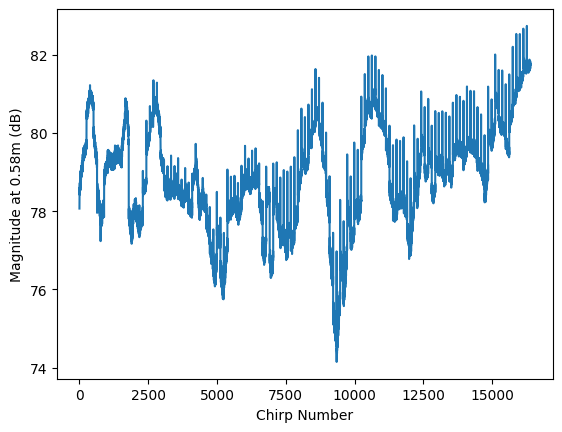

In [353]:
plt.plot(np.arange(len(magAt58cm)),magAt58cm)
plt.xlabel('Chirp Number')
plt.ylabel('Magnitude at 0.58m (dB)')

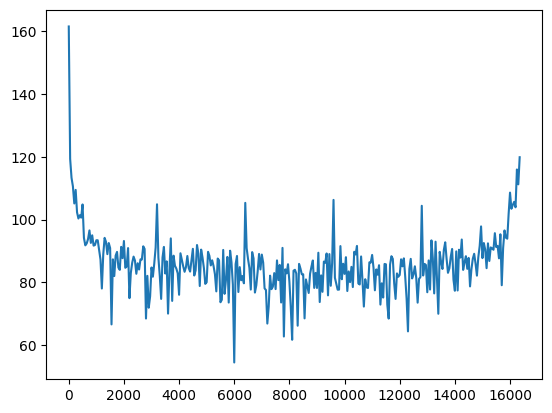

In [356]:
# def dopFFT(signal, plot=False):
#     global range_max
#     num_samples = len(signal)
#     window = np.hanning(num_samples)
#     signal_windowed = signal * window
#     y=np.fft.fft(signal_windowed)
#     fft_magnitude = magnitude_db(y,)
#     # fft_magnitude = magnitude_dbfs(y,adc_bits=16)

#     # frequencies = np.fft.fftshift(np.fft.fftfreq(num_samples, d=1/(sampling_frequency)))
#     # distances=np.abs(frequencies)*3e8/2/S
#     distances=np.arange(num_samples) * range_max / num_samples
#     # print([distances[0],distances[-100]])
#     if plot:
#         # Plot the magnitude spectrum
#         plt.figure(figsize=(10, 5))
#         # plt.plot(frequencies[:num_samples//2], fft_magnitude[:num_samples//2]) # Plot only positive frequencies
#         # plt.plot(distances[:num_samples//2], fft_magnitude[:num_samples//2]) # Plot only positive frequencies
#         plt.plot(distances, fft_magnitude) # Plot only positive frequencies
#         plt.title('Magnitude Spectrum (Range Profile)')
#         # plt.xlabel('Frequency (Hz) / Range Bins')
#         plt.xlabel('Distances (m)')
#         plt.ylabel('Magnitude [dBFS]')
#         plt.xticks(np.arange(0,range_max,5))
#         plt.grid(True)
#         plt.axvline(x=0.6, color='r', linestyle='--', alpha=0.5)
#         plt.show()
#     return y, fft_magnitude, distances

dop_fft=np.fft.fft(sigAt58cm)
skip=50
plt.plot(np.arange(len(dop_fft)/skip)*skip,magnitude_db(dop_fft)[::skip])